In [ ]:
# Loading Pre-Trained Concepts
# ----------------------------------- 
# This notebook demonstrates how to load fine-tuned stable diffusion concepts
# Concepts are the product of textual inversion training sessions
# This currently works fine in colab but it clearly needs a lot of work

In [ ]:
# Mixed Introduction Notes
# -----------------------------------

# The Stable Conceptualizer enables you to use pre-learned concepts on Stable Diffusion via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

# ![Textual Inversion example](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

# Navigate the [library of pre-learned concepts](https://huggingface.co/sd-concepts-library) here. For teaching the model new concepts using Textual Inversion, [use this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb). 


## Initial setup

In [1]:
#@title Install the required libs
!pip install -qq diffusers==0.11.1 transformers ftfy accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.5 MB/s eta 0:00:00


In [2]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
#@title Import required libraries
import os
import torch

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Run Stable Diffusion with pre-trained Learned Concepts
If you want to teach Stable Diffusion your own concepts, [use this notebook](#). 



In [5]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use. This should match the one used for training the embeddings.
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param {type:"string"}

In [6]:
from IPython.display import Markdown
from huggingface_hub import hf_hub_download
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/ahx-model-5" #@param {type:"string"}


#@markdown (Optional) in case you have a `learned_embeds.bin` file and not a `repo_id`, add the path to `learned_embeds.bin` to the `embeds_url` variable 
embeds_url = "" #Add the URL or path to a learned_embeds.bin file in case you have one
placeholder_token_string = "" #Add what is the token string in case you are uploading your own embed

downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
  os.mkdir(downloaded_embedding_folder)
if(not embeds_url):
  embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin")
  token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt")
  !cp $embeds_path $downloaded_embedding_folder
  !cp $token_path $downloaded_embedding_folder
  with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
    placeholder_token_string = file.read()
else:
  !wget -q -O $downloaded_embedding_folder/learned_embeds.bin $embeds_url

learned_embeds_path = f"{downloaded_embedding_folder}/learned_embeds.bin"

display (Markdown("## The placeholder token for your concept is `%s`"%(placeholder_token_string)))

## The placeholder token for your concept is `<ahx-model-4>`

In [7]:
#@title Set up the Tokenizer and the Text Encoder
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16
)

In [8]:
#@title Load the newly learned embeddings into CLIP
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds
load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer)

In [9]:
#@title Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [17]:
print(f"The placeholder token for the imported model is {placeholder_token_string}")

The placeholder token for the imported model is <ahx-model-4>


  0%|          | 0/30 [00:00<?, ?it/s]

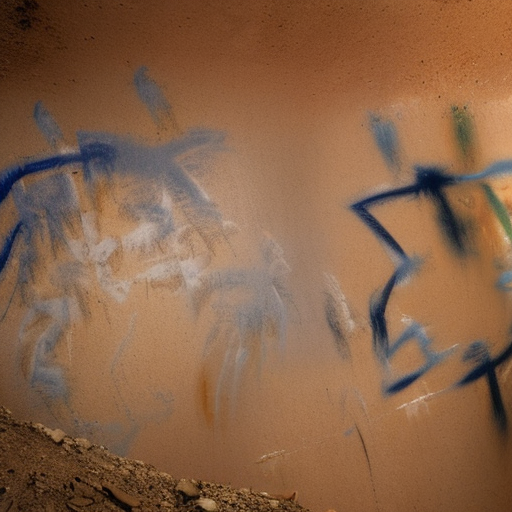

In [20]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a star man in the style of \u003Cahx-model-4>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, height=512, width=512, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid